<a href="https://colab.research.google.com/github/radwaahmed20112000/Speech-Emotion-Recognition-/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Load data**

In [ ]:
%matplotlib inline
import librosa as librosa
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os
import librosa.display
from IPython.display import Audio
from google.colab import drive

Upload Data from Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import io
zf = zipfile.ZipFile('/content/drive/MyDrive/Crema.zip')
zf.extractall('dataSet')

In [ ]:
PATH = "/content/dataSet/Crema/"

Create sample data frame of path and meta data

In [ ]:
df = pd.DataFrame(columns = ["Path", "Actor", "Gender", "Intensity",
                             "Statement", "Emotion"])
i = 0

for filename in os.listdir(PATH):
  
  filename_split = filename.split(".")[0].split("_")
  Path = PATH + filenamefit_transform

  Actor = filename_split[0]
  if int(filename_split[0]) % 2 == 0:
    Gender = "female"
  else:
    Gender = "male"

  Statement = filename_split[1]

  Emotion = filename_split[2]
  
  Intensity = filename_split[3]

  df.loc[i] = [Path, Actor, Gender, Intensity, Statement, Emotion]
  i += 1
  df.loc[i] = [Path, Actor, Gender, Intensity, Statement, Emotion]
  i += 1
df

,Path,Actor,Gender,Intensity,Statement,Emotion
0,/content/dataSet/Crema/1082_IWL_FEA_XX.wav,1082,female,XX,IWL,FEA
1,/content/dataSet/Crema/1082_IWL_FEA_XX.wav,1082,female,XX,IWL,FEA
2,/content/dataSet/Crema/1062_TSI_HAP_XX.wav,1062,female,XX,TSI,HAP
3,/content/dataSet/Crema/1062_TSI_HAP_XX.wav,1062,female,XX,TSI,HAP
4,/content/dataSet/Crema/1013_IEO_FEA_MD.wav,1013,male,MD,IEO,FEA
...,...,...,...,...,...,...
14879,/content/dataSet/Crema/1016_TIE_ANG_XX.wav,1016,female,XX,TIE,ANG
14880,/content/dataSet/Crema/1070_IWL_FEA_XX.wav,1070,female,XX,IWL,FEA
14881,/content/dataSet/Crema/1070_IWL_FEA_XX.wav,1070,female,XX,IWL,FEA
14882,/content/dataSet/Crema/1043_IOM_DIS_XX.wav,1043,male,XX,IOM,DIS


# **1D Feature Spaces**

### Augmentation Functions


In [ ]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

In [ ]:
def time_stretch(signal, time_stretch_rate):
    return librosa.effects.time_stretch(signal, time_stretch_rate)

In [ ]:
def pitch_scale(signal, sr, num_semitones):
    return librosa.effects.pitch_shift(signal, sr, num_semitones)

### Features Functions

In [ ]:
def get_zero_crossing_rate(samples, sampling_rate):
  zcrs = librosa.feature.zero_crossing_rate(samples).flatten() 
  zcrs = librosa.feature.mfcc(y=zcrs, sr=sampling_rate,n_mfcc=100)
  return zcrs.mean(axis = 1)

In [ ]:
def get_rms(samples, sampling_rate):    
  rms = librosa.feature.rms(S=samples).flatten()
  rms = librosa.feature.mfcc(y=rms, sr=sampling_rate,n_mfcc=100)
  rms = rms.mean(axis = 1)

In [ ]:
def get_rms_mfcc(samples, sampling_rate):
  s, phase = librosa.magphase(librosa.stft(samples))
  rms = librosa.feature.rms(S=s).flatten()
  times = librosa.feature.mfcc(y=rms, sr=sampling_rate, n_mfcc=200).mean(axis = 1)
  return times

In [ ]:
def gender_concatanation(data_1d_aug):
  data_1d_aug = pd.DataFrame(data_1d_aug)
  data_1d_aug['gender'] = df["Gender"].map(dict(male=1, female=0))
  data_1d_aug["labels"] = df["Emotion"]
  return data_1d_aug.values.tolist()

### 1-Samples with mfcc only

In [ ]:
data_1d = []

for path in df["Path"]:
    samples, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
    samples = librosa.feature.mfcc(y=samples, sr=sampling_rate, n_mfcc=200)
    samples = samples.mean(axis = 1)
    data_1d.append(samples)

data_1d = pd.DataFrame(data_1d)
data_1d["labels"] = df["Emotion"]
data_1d

### 2- Zcrs with fillna only

In [ ]:
data_1d = []

for path in df["Path"]:
    samples , sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
    zcrs = librosa.feature.zero_crossing_rate(samples).flatten()
 
    data_1d.append(zcrs)

data_1d = pd.DataFrame(data_1d)
data_1d.fillna(data_1d.mean(axis=1),axis=0, inplace=True)
data_1d["labels"] = df["Emotion"]
data_1d

### 3- Rms with fillna only

In [ ]:
data_1d=[]
for path in df["Path"]:
    samples , sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
  
    S, phase = librosa.magphase(librosa.stft(samples))
    rms = librosa.feature.rms(S=S)
    times = librosa.times_like(rms)
    data_1d.append(times)

data_1d = pd.DataFrame(data_1d)
data_1d.fillna(data_1d.mean(axis=1),axis=0, inplace=True)
data_1d["labels"] = df["Emotion"]
data_1d

### 4- Zrfc + Rms with fillna

In [ ]:
data_zcr_1d = []
data_rms_1d=[]
for path in df["Path"]:
    samples , sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
    zcrs = librosa.feature.zero_crossing_rate(samples).flatten() 
    data_zcr_1d.append(zcrs)

    S, phase = librosa.magphase(librosa.stft(samples))
    rms = librosa.feature.rms(S=S)
    times = librosa.times_like(rms)
    data_rms_1d.append(times)

data_zcr_1d = pd.DataFrame(data_zcr_1d)
data_zcr_1d.fillna(data_zcr_1d.mean(axis=1),axis=0, inplace=True)

data_rms_1d = pd.DataFrame(data_rms_1d)
data_rms_1d.fillna(data_rms_1d.mean(axis=1),axis=0, inplace=True)

data_1d = pd.concat([data_zcr_1d, data_rms_1d] , axis=1, join='inner')
data_1d["labels"] = df["Emotion"]

data_1d

### 5- Sample with mfcc 50 + Zcr + Rms with fillna

In [ ]:
data_sample_1d = []
data_zcr_1d = []
data_rms_1d=[]
for path in df["Path"]:
    samples , sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
    zcrs = librosa.feature.zero_crossing_rate(samples).flatten() 
    data_zcr_1d.append(zcrs)

    S, phase = librosa.magphase(librosa.stft(samples))
    rms = librosa.feature.rms(S=S)
    times = librosa.times_like(rms)
    data_rms_1d.append(times)

    samples = librosa.feature.mfcc(y=samples, sr=sampling_rate,n_mfcc=50)
    samples = samples.mean(axis = 1)
    data_sample_1d.append(samples)
   

data_zcr_1d = pd.DataFrame(data_zcr_1d)
data_zcr_1d.fillna(data_zcr_1d.mean(axis=1),axis=0, inplace=True)

data_sample_1d = pd.DataFrame(data_sample_1d)

data_rms_1d = pd.DataFrame(data_rms_1d)
data_rms_1d.fillna(data_rms_1d.mean(axis=1),axis=0, inplace=True)

data_1d = pd.concat([data_sample_1d, data_zcr_1d,data_rms_1d] , axis=1, join='inner')
data_1d["labels"] = df["Emotion"]
data_1d


### 6- Mfcc + Gender Features

In [ ]:
data_1d = []
gender = []

for index, data in df.iterrows():
  path = data['Path']
  samples , sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
  samples = librosa.feature.mfcc(y=samples, sr=sampling_rate, n_mfcc=200)
  samples = samples.mean(axis = 1)
  
  data_1d.append(samples)

  if data["Gender"] == 'male':
    gender.append(0)
  else:
    gender.append(1)

data_1d = pd.DataFrame(data_1d)
gender = pd.DataFrame(gender)
data_1d = pd.concat([gender, data_1d] , axis=1, join='inner')
data_1d["labels"] = df["Emotion"]

#data_1d

KeyboardInterrupt: ignored

### 7- Mfcc + Gender + White Noise Augmentation 


In [ ]:
data_1d = []
gender = []
i = 0

for index, data in df.iterrows():

  path = data['Path']
  samples, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
  augmented_signal = add_white_noise(samples, 0.1)

  samples = librosa.feature.mfcc(y=samples, sr=sampling_rate, n_mfcc=200).mean(axis = 1)
  augmented_signal = librosa.feature.mfcc(y=augmented_signal, sr=sampling_rate, n_mfcc=200).mean(axis = 1)

  data_1d.append(samples)
  data_1d.append(augmented_signal)

  if data["Gender"] == 'male':
    gender.append(0)
    gender.append(0)
  else:
    gender.append(1)
    gender.append(1)


data_1d = pd.DataFrame(data_1d)
gender = pd.DataFrame(gender)
data_1d = pd.concat([gender, data_1d] , axis=1, join='inner')
data_1d["labels"] = df["Emotion"]

### 8- Mfcc + Gender + 3 layers of Augmentation

In [ ]:
import tensorflow as tf
%tensorflow_version 2.x
data_1d_aug = []
data_1d_samples = []
data_1d_aug_1 = []
data_1d_aug_2 = []

for path in df["Path"]:
  
    samples , sampling_rate = librosa.load(path, sr = None, mono = True, 
                                           offset = 0.0)
    data_1d_samples.append(librosa.feature.mfcc(y=samples, sr=sampling_rate, 
                                                n_mfcc=200).mean(axis = 1)) 

    #Augumentation: White Noise
    aug_samples = add_white_noise(samples, 0.1)
    data_1d_aug.append(librosa.feature.mfcc(y=aug_samples, sr=sampling_rate, 
                                            n_mfcc=200).mean(axis = 1))

    #Augumentation: Pitch Scale
    aug_samples = pitch_scale(samples, sampling_rate, 2)
    data_1d_aug_2.append(librosa.feature.mfcc(y=aug_samples, sr=sampling_rate, 
                                              n_mfcc=200).mean(axis = 1)) 

    #Augumentation: Time Stretch 
    aug_samples = librosa.effects.time_stretch(samples , .8)
    data_1d_aug_1.append(librosa.feature.mfcc(y=aug_samples, sr=sampling_rate, 
                                              n_mfcc=200).mean(axis = 1)) 

data_1d_aug = gender_concatanation(data_1d_aug)

data_1d_aug_1 = gender_concatanation(data_1d_aug_1)

data_1d_samples = gender_concatanation(data_1d_samples)

data_1d_aug_2 = gender_concatanation(data_1d_aug_2)

data_1d = pd.DataFrame(data_1d_aug + data_1d_samples + data_1d_aug_1 
                       + data_1d_aug_2)

In [ ]:
labels = data_1d.iloc[:,-1:]
data_1d = data_1d.iloc[: , :-1]
data_1d['labels'] = labels
data_1d

### 9- Mfcc + Gender + RMS + 3 layers of Augmentation

In [ ]:
import tensorflow as tf
%tensorflow_version 2.x
data_1d_aug = []
data_1d_samples = []
data_1d_aug_1 = []
data_1d_aug_2 = []

for path in df["Path"]:
    
    samples , sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
    times = get_rms_mfcc(samples, sampling_rate)
    data_1d_samples.append(np.append(librosa.feature.mfcc(y=samples, sr=sampling_rate, n_mfcc=200).mean(axis = 1), times)) 

    #Augumentation
    aug_samples = add_white_noise(samples, 0.1)
    S, phase = librosa.magphase(librosa.stft(aug_samples))

    data_1d_aug.append(np.append(librosa.feature.mfcc(y=aug_samples, sr=sampling_rate,n_mfcc=200).mean(axis = 1), times))

    #Augumentation
    aug_samples = librosa.effects.time_stretch(samples , .8)
    times = get_rms_mfcc(samples, sampling_rate)
    data_1d_aug_1.append(np.append(librosa.feature.mfcc(y=aug_samples, sr=sampling_rate,n_mfcc=200).mean(axis = 1), times))

    #Augumentation
    aug_samples = librosa.effects.pitch_shift(samples, sampling_rate, 2)
    times = get_rms_mfcc(samples, sampling_rate)
    data_1d_aug_2.append(np.append(librosa.feature.mfcc(y=aug_samples, sr=sampling_rate,n_mfcc=200).mean(axis = 1), times))

data_1d_aug = gender_concatanation(data_1d_aug)

data_1d_aug_1 = gender_concatanation(data_1d_aug_1)

data_1d_samples = gender_concatanation(data_1d_samples)

data_1d_aug_2 = gender_concatanation(data_1d_aug_2)

data_1d = pd.DataFrame(data_1d_aug + data_1d_samples + data_1d_aug_1 
                       + data_1d_aug_2)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=82
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=102
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=82
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=102
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=65
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=81
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spec

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,-240.127681,37.447224,4.119642,6.156446,-1.472156,3.843342,-2.062184,-3.261164,3.070111,-1.690560,...,14.549550,1.028104,-14.313123,-13.603321,-8.869075,-6.680773,3.177949,6.172023,0,FEA
1,-240.362210,38.173442,3.997397,6.501393,-0.774234,3.919050,-2.527265,-3.469273,3.299474,-1.563311,...,14.280008,0.912823,-14.425523,-13.200235,-8.580072,-6.726829,2.986388,5.847531,0,FEA
2,-353.295581,69.051191,50.824127,31.862356,10.602760,7.767115,-2.547678,-0.579521,1.247110,-2.196308,...,-12.882103,3.484066,1.644587,-0.077457,-5.648213,-1.056162,1.090621,3.221547,0,HAP
3,-352.637118,68.937595,51.114264,31.170898,9.895204,7.970283,-1.483309,-0.838678,1.104268,-2.445870,...,-12.790413,3.491072,1.596009,0.075954,-5.674416,-1.023158,1.134210,3.221698,0,HAP
4,-385.915731,79.980752,45.737008,27.407061,19.652832,11.843059,4.182976,-1.161363,1.846133,1.593922,...,-4.867364,8.390226,4.178423,-2.223155,-8.438019,-3.504152,6.158884,8.886946,1,FEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59531,-283.734344,100.740471,1.310934,19.875299,0.539823,-11.401859,-7.889131,-4.821404,-1.495032,-4.352018,...,-6.046443,3.924463,9.964572,13.222437,12.113013,15.530333,3.211624,-3.632397,0,ANG
59532,-401.490387,129.331390,28.389742,18.210348,-7.222347,7.855520,-1.291056,-8.747037,-2.346614,-0.047844,...,-4.122837,7.366165,16.952457,8.277471,1.382034,-10.280244,-13.267412,-22.050552,0,FEA
59533,-401.490387,129.331390,28.389742,18.210348,-7.222347,7.855520,-1.291056,-8.747037,-2.346614,-0.047844,...,-4.122837,7.366165,16.952457,8.277471,1.382034,-10.280244,-13.267412,-22.050552,0,FEA
59534,-407.652618,101.561592,31.995092,40.425533,-11.165421,7.246223,-9.429075,-6.946307,1.900549,-1.656801,...,-4.115865,7.024977,4.048615,3.696505,-0.870000,-2.402125,-3.117244,-6.371015,1,DIS


In [ ]:
labels = data_1d.iloc[:,-1:]
data_1d = data_1d.iloc[: , :-1]
data_1d['labels'] = labels
data_1d

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,labels
0,-240.127681,37.447224,4.119642,6.156446,-1.472156,3.843342,-2.062184,-3.261164,3.070111,-1.690560,...,14.549550,1.028104,-14.313123,-13.603321,-8.869075,-6.680773,3.177949,6.172023,0,FEA
1,-240.362210,38.173442,3.997397,6.501393,-0.774234,3.919050,-2.527265,-3.469273,3.299474,-1.563311,...,14.280008,0.912823,-14.425523,-13.200235,-8.580072,-6.726829,2.986388,5.847531,0,FEA
2,-353.295581,69.051191,50.824127,31.862356,10.602760,7.767115,-2.547678,-0.579521,1.247110,-2.196308,...,-12.882103,3.484066,1.644587,-0.077457,-5.648213,-1.056162,1.090621,3.221547,0,HAP
3,-352.637118,68.937595,51.114264,31.170898,9.895204,7.970283,-1.483309,-0.838678,1.104268,-2.445870,...,-12.790413,3.491072,1.596009,0.075954,-5.674416,-1.023158,1.134210,3.221698,0,HAP
4,-385.915731,79.980752,45.737008,27.407061,19.652832,11.843059,4.182976,-1.161363,1.846133,1.593922,...,-4.867364,8.390226,4.178423,-2.223155,-8.438019,-3.504152,6.158884,8.886946,1,FEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59531,-283.734344,100.740471,1.310934,19.875299,0.539823,-11.401859,-7.889131,-4.821404,-1.495032,-4.352018,...,-6.046443,3.924463,9.964572,13.222437,12.113013,15.530333,3.211624,-3.632397,0,ANG
59532,-401.490387,129.331390,28.389742,18.210348,-7.222347,7.855520,-1.291056,-8.747037,-2.346614,-0.047844,...,-4.122837,7.366165,16.952457,8.277471,1.382034,-10.280244,-13.267412,-22.050552,0,FEA
59533,-401.490387,129.331390,28.389742,18.210348,-7.222347,7.855520,-1.291056,-8.747037,-2.346614,-0.047844,...,-4.122837,7.366165,16.952457,8.277471,1.382034,-10.280244,-13.267412,-22.050552,0,FEA
59534,-407.652618,101.561592,31.995092,40.425533,-11.165421,7.246223,-9.429075,-6.946307,1.900549,-1.656801,...,-4.115865,7.024977,4.048615,3.696505,-0.870000,-2.402125,-3.117244,-6.371015,1,DIS


# **Balanced Data Split**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data_1d, data_1d['labels'], 
                                                    test_size=0.3, random_state=0, stratify=data_1d['labels'])

X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, X_train['labels'], 
                                                    test_size=0.05, random_state=0, stratify=X_train['labels'])

X_train = X_train.drop(columns="labels")
X_validation = X_validation.drop(columns="labels")
X_test = X_test.drop(columns="labels")

### Labels Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

Y_train = np.array(Y_train)
lb = LabelEncoder()
Y_train = to_categorical(lb.fit_transform(Y_train))

Y_validation = np.array(Y_validation)
lb = LabelEncoder()
Y_validation = to_categorical(lb.fit_transform(Y_validation))

Y_test = np.array(Y_test)
lb = LabelEncoder()
Y_test = to_categorical(lb.fit_transform(Y_test))

### Data Normalization

In [ ]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_validation = (X_validation - mean)/std
X_test = (X_test - mean)/std


# **1D Models**

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

### Model 1 : Pdf Model (Done)

In [2]:
def conv_1d():
  
  model = tf.keras.Sequential()

  model.add(layers.Conv1D(512, kernel_size=(5), activation='relu', input_shape=(X_train.shape[1],1),strides=(1)))
  model.add(layers.MaxPooling1D(pool_size=(5),strides=(2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv1D(512, kernel_size=(5), activation='relu', strides=(1)))
  model.add(layers.MaxPooling1D(pool_size=(5),strides=(2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv1D(128, kernel_size=(5), activation='relu', strides=(1)))
  model.add(layers.MaxPooling1D(pool_size=(5), strides=(2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(6, activation='softmax'))
  opt = keras.optimizers.Adam(lr=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  return model

### Model 2 (Done)

In [3]:
def conv_1d():
  CNN_model = Sequential()

  CNN_model.add(layers.Conv1D(16, 5, padding='same',
                  input_shape=(X_train.shape[1],1), activation='relu'))

  CNN_model.add(layers.Conv1D(32, 5,padding='same',activation='relu'))

  CNN_model.add(layers.Conv1D(64, 5,padding='same',activation='relu'))

  CNN_model.add(layers.Conv1D(128, 5,padding='same',activation='relu'))

  CNN_model.add(layers.Dropout(0.1))

  CNN_model.add(layers.Flatten())

  CNN_model.add(layers.Dense(128, activation ='relu'))
  CNN_model.add(layers.Dropout(0.1))
  CNN_model.add(layers.Dense(256, activation ='relu'))
  CNN_model.add(layers.Dense(6, activation='softmax'))
  CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])
  CNN_model.summary()

  return CNN_model

### Model 3

In [4]:
def conv_1d():
  CNN_model = Sequential()

  CNN_model.add(layers.Conv1D(512, kernel_size=(5), activation='relu', 
                              input_shape=(X_train.shape[1],1),strides=(1)))

  CNN_model.add(layers.Conv1D(128, 5, padding='same', activation='relu'))

  CNN_model.add(layers.Conv1D(32, 5, padding='same', activation='relu'))

  CNN_model.add(layers.Conv1D(64, 5, padding='same', activation='relu'))

  CNN_model.add(layers.Conv1D(128, 5, padding='same', activation='relu'))

  CNN_model.add(layers.Dropout(0.1))

  CNN_model.add(layers.Flatten())

  CNN_model.add(layers.Dense(128, activation ='relu'))
  CNN_model.add(layers.Dropout(0.1))
  CNN_model.add(layers.Dense(256, activation ='relu'))
  CNN_model.add(layers.Dense(6, activation='softmax'))
  CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])
  CNN_model.summary()

  return CNN_model

### Model 4 ( AlexNet Model )


In [5]:
def conv_1d():
  CNN_model = Sequential()

  CNN_model.add(layers.Conv1D(96, kernel_size=(11), activation='relu', 
                              input_shape=(X_train.shape[1],1)
                              ,strides=(1)))

  CNN_model.add(layers.Conv1D(256, 3, padding='same', activation='relu'))

  CNN_model.add(layers.MaxPooling1D(pool_size=(5),strides=(2)))

  CNN_model.add(layers.Conv1D(384, 3, padding='same', activation='relu'))

  CNN_model.add(layers.MaxPooling1D(pool_size=(5),strides=(2)))

  CNN_model.add(layers.Conv1D(384, 3, padding='same', activation='relu'))

  CNN_model.add(layers.Conv1D(256, 3, padding='same', activation='relu'))

  CNN_model.add(layers.MaxPooling1D(pool_size=(5),strides=(2)))

  CNN_model.add(layers.Flatten())

  CNN_model.add(layers.Dense(4096, activation ='relu'))
  CNN_model.add(layers.Dropout(0.1))
  CNN_model.add(layers.Dense(4096, activation ='relu'))
  CNN_model.add(layers.Dense(4096, activation='relu'))
  CNN_model.add(layers.Dense(1000, activation='relu'))
  CNN_model.add(layers.Dense(6, activation='softmax'))

  CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])
  CNN_model.summary()

  return CNN_model

### Model 5 ( VGG 16 )


In [6]:
def conv_1d():
  CNN_model = Sequential()

  CNN_model.add(layers.Conv1D(64, kernel_size=(3), activation='relu', 
                              input_shape=(X_train.shape[1],1)
                              ,strides=(1)))

  CNN_model.add(layers.Conv1D(64, 3, padding='same', activation='relu'))

  CNN_model.add(layers.MaxPooling1D(pool_size=(5),strides=(2)))

  CNN_model.add(layers.Conv1D(128, 3, padding='same', activation='relu'))

  CNN_model.add(layers.Conv1D(128, 3, padding='same', activation='relu'))

  CNN_model.add(layers.MaxPooling1D(pool_size=(5),strides=(2)))

  CNN_model.add(layers.Conv1D(512, 3, padding='same', activation='relu'))

  CNN_model.add(layers.Conv1D(512, 3, padding='same', activation='relu'))

  CNN_model.add(layers.Conv1D(512, 3, padding='same', activation='relu'))

  CNN_model.add(layers.MaxPooling1D(pool_size=(5),strides=(2)))

  CNN_model.add(layers.Conv1D(512, 3, padding='same', activation='relu'))

  CNN_model.add(layers.Conv1D(512, 3, padding='same', activation='relu'))
  
  CNN_model.add(layers.Conv1D(512, 3, padding='same', activation='relu'))

  CNN_model.add(layers.MaxPooling1D(pool_size=(5),strides=(2)))

  CNN_model.add(layers.Flatten())

  CNN_model.add(layers.Dense(4096, activation ='relu'))
  CNN_model.add(layers.Dense(4096, activation ='relu'))
  CNN_model.add(layers.Dense(1000, activation='relu'))
  CNN_model.add(layers.Dense(6, activation='softmax'))

  CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])
  CNN_model.summary()

  return CNN_model

### Run Model

In [7]:
model = conv_1d()
model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size=60,
          validation_data=(X_validation, Y_validation))

NameError: ignored

# **Big Picture**

### Calculate Accuracy ansd F Score For each Class

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
prediction = np.argmax(model.predict(X_test), axis=1)

actual = np.argmax(Y_test, axis=1)

In [ ]:
print("Accuracy: ")
print(model.evaluate(X_test, Y_test)[1]*100)

In [ ]:
print("F_Score: ")
f_score = f1_score(actual, prediction, average=None)
print(f_score)

### Plot the confusion matrices and find the most confusing classes

In [ ]:
mcm = confusion_matrix(actual, prediction)

print("Most Confusing Class is " + str(np.argmin(f_score)))
print("")
plot_confusion_matrix(mcm, [0, 1, 2, 3, 4, 5])

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f};      misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# **Trial**

In [ ]:
from os import path
from pydub import AudioSegment

# files
src = input("In: ")
dst = input("Out: ")

# convert mp3 to wav
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

# **2D Feature Space**

In [ ]:
from tensorflow.keras.optimizers import SGD
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import np_utils as utils
from keras.layers import Dropout, Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import statistics
import math
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

### Augmentation Functions


In [ ]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

In [ ]:
def time_stretch(signal, time_stretch_rate):
    return librosa.effects.time_stretch(signal, time_stretch_rate)

In [ ]:
def pitch_scale(signal, sr, num_semitones):
    return librosa.effects.pitch_shift(signal, sr, num_semitones)

### First way (saving as images and load them)

#### Delete Folders

In [ ]:
# %rm -rf melspec

#### Create Folders

In [ ]:
import os

path = "/content/melspec"
os.mkdir(path)
path = "/content/melspec/angry"
os.mkdir(path)
path = "/content/melspec/sad"
os.mkdir(path)
path = "/content/melspec/happy"
os.mkdir(path)
path = "/content/melspec/disappointed"
os.mkdir(path)
path = "/content/melspec/fear"
os.mkdir(path)
path = "/content/melspec/neutral"
os.mkdir(path)

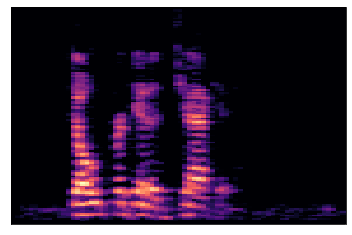

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,...,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388
1,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,...,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388
2,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,...,-31.029388,-31.029388,-28.765499,-29.934116,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388
3,-31.029388,-31.029388,-31.029388,-31.029388,-28.974932,-22.468418,-25.174671,-22.052307,-21.853062,-31.029388,...,-27.625393,-25.022465,-22.212254,-20.763462,-26.680948,-27.081490,-27.670593,-31.029388,-31.029388,-30.628950
4,-31.029388,-27.037201,-24.304409,-31.029388,-29.227392,-26.809952,-27.783161,-30.659941,-29.384464,-30.010853,...,-31.029388,-30.547764,-28.286669,-31.029388,-29.081057,-31.029388,-30.928070,-31.029388,-31.029388,-31.029388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,...,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388
124,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,...,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388
125,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,...,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388
126,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,...,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388,-31.029388


In [ ]:
samples, sampling_rate = librosa.load("/content/dataSet/Crema/1001_DFA_ANG_XX.wav", sr = None, mono = True, offset = 0.0)

# samples = samples[:100000] # shorten audio a bit for speed

rbSpec = librosa.feature.melspectrogram(y = samples, sr = sampling_rate)

# Convert amplitudes to dB

rbSpec = librosa.amplitude_to_db(rbSpec)

# For saving imgs
librosa.display.specshow(rbSpec,cmap = 'magma', )
plt.margins(0,0)
plt.savefig("test.png",bbox_inches='tight', pad_inches = 0)
plt.show()
d= pd.DataFrame(rbSpec)
d

#### Generate and save melspectrogram images

In [ ]:
labels = df["Emotion"]
s = 0
h = 0
f = 0
n = 0
a = 0
d = 0
counter = 0

for path in df["Path"]:
  # if counter < 121:
    samples, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)

    # samples = samples[:100000] # shorten audio a bit for speed

    rbSpec = librosa.feature.melspectrogram(y = samples, sr = sampling_rate)
    
    # Convert amplitudes to dB
    
    rbSpec = librosa.amplitude_to_db(rbSpec)

    # For saving imgs

    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    p = librosa.display.specshow(rbSpec, ax = ax, cmap = 'magma')
    if (labels[counter] == "ANG"):
      cl = "angry"
      i = a
      a += 1
    elif (labels[counter] == "HAP"):
      cl = "happy"
      i = h
      h += 1
    elif (labels[counter] == "FEA"):
      cl = "fear"
      i = f
      f += 1
    elif (labels[counter] == "NEU"):
      cl = "neutral"
      i = n
      n += 1
    elif (labels[counter] == "DIS"):
      cl = "disappointed"
      i = d
      d += 1
    elif (labels[counter] == "SAD"):
      cl = "sad"
      i = s
      s +=1
    fig.savefig("/content/melspec/" + cl + '/' + str(i) + ".png", bbox_inches='tight', pad_inches = 0)
    
    counter+=1

### Second way (dealing with generated arrays)

#### Get the mean of samples size

#### 1- Original data

In [ ]:
## get length of samples
def get_avg_len():
  audios = []
  for path in df["Path"]:
    # if counter < 121:
      samples, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
      audios.append(len(samples))

  avg_len = math.floor(statistics.mean(audios))
  return avg_len

#### 2- With white noise

In [ ]:
## get length of samples
def get_avg_len_with_white():
  audios = []
  for path in df["Path"]:
      samples, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
      audios.append(len(samples))
      augment_samples = librosa.effects.time_stretch(samples , .8)
      audios.append(len(augment_samples))

  avg_len = math.floor(statistics.mean(audios))
  return avg_len

#### 3- With white noise and pitch scale

In [ ]:
## get length of samples
def get_avg_len_with_white_stretch():
  audios = []
  for path in df["Path"]:
      samples, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
      audios.append(len(samples))
      augmented_signal = add_white_noise(samples, 0.1)
      audios.append(len(augmented_signal))
      aug_signal = pitch_scale(samples, sampling_rate, 2)
      audios.append(len(aug_signal))

  avg_len = math.floor(statistics.mean(audios))
  return avg_len

4- With 3 layers of augmentation

In [ ]:
## get length of samples
def get_avg_len_with_layers():
  audios = []
  for path in df["Path"]:
      samples, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
      audios.append(len(samples))
      augmented_signal = add_white_noise(samples, 0.1)
      audios.append(len(augmented_signal))
      aug_signal = pitch_scale(samples, sampling_rate, 2)
      audios.append(len(aug_signal))
      augment_samples = librosa.effects.time_stretch(samples , .8)
      audios.append(len(augment_samples))

  avg_len = math.floor(statistics.mean(audios))
  return avg_len

#### Resize data

#### 1- Original data

In [ ]:
def get_label(label):
  i = 0
  if (label == "ANG"):
    i = 0
  elif (label == "HAP"):
    i = 1
  elif (label == "FEA"):
    i = 2
  elif (label == "NEU"):
    i = 3
  elif (label == "DIS"):
    i = 4
  elif (label == "SAD"):
    i = 5
  return i

In [ ]:
def generate_melspec(avg_len):
  labels = df["Emotion"]
  counter = 0
  data = []
  label = []

  for path in df["Path"]:
      samples, sampling_rate = librosa.load(path, sr = 16000, mono = True, offset = 0.0)

      if len(samples) > avg_len:  #if length of audio > avg_len, remove the difference
          max_offset = len(samples)-avg_len
          offset = np.random.randint(max_offset)
          samples = samples[offset:(avg_len+offset)]
      else:
          if avg_len > len(samples): #if length < avg_len, add padding
              max_offset = avg_len - len(samples)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          samples = np.pad(samples, (offset, avg_len - len(samples) - offset), "constant") 


      rbSpec = librosa.feature.melspectrogram(y = samples, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)

      i = get_label(labels[counter])

      label.append(i)
      data.append(rbSpec)
      counter+=1
  data = np.array(data)
  labels = np.array(label)
  le = LabelEncoder()
  labels = to_categorical(le.fit_transform(labels)) 
  return data, labels

#### 2- With white noise

In [ ]:
def generate_melspec_with_white(avg_len):
  labels = df["Emotion"]
  counter = 0
  data = []
  label = []

  for path in df["Path"]:
      samples, sampling_rate = librosa.load(path, sr = 16000, mono = True, offset = 0.0)
      augmented_signal = librosa.effects.time_stretch(samples , .8)

      
      if len(samples) > avg_len:  #if length of audio > avg_len, remove the difference
          max_offset = len(samples)-avg_len
          offset = np.random.randint(max_offset)
          samples = samples[offset:(avg_len+offset)]
      else:
          if avg_len > len(samples): #if length < avg_len, add padding
              max_offset = avg_len - len(samples)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          samples = np.pad(samples, (offset, avg_len - len(samples) - offset), "constant") 


      rbSpec = librosa.feature.melspectrogram(y = samples, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)

      i = get_label(labels[counter])

      label.append(i)
      data.append(rbSpec)

      #Augumentation: White Noise
      if len(augmented_signal) > avg_len:  #if length of audio > avg_len, remove the difference
        max_offset = len(augmented_signal)-avg_len
        offset = np.random.randint(max_offset)
        augmented_signal = augmented_signal[offset:(avg_len+offset)]
      else:
          if avg_len > len(augmented_signal): #if length < avg_len, add padding
              max_offset = avg_len - len(augmented_signal)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          augmented_signal = np.pad(augmented_signal, (offset, avg_len - len(augmented_signal) - offset), "constant") 


      rbSpec = librosa.feature.melspectrogram(y = augmented_signal, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)


      label.append(i)
      data.append(rbSpec)

      counter+=1
      
  data = np.array(data)
  labels = np.array(label)
  le = LabelEncoder()
  labels = to_categorical(le.fit_transform(labels)) 
  return data, labels

#### 3- With white noise and time stretch

In [ ]:
def generate_melspec_with_white_stretch(avg_len):
  labels = df["Emotion"]
  counter = 0
  data = []
  label = []

  for path in df["Path"]:
      samples, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
      augmented_signal = add_white_noise(samples, 0.1)
      aug_samples = pitch_scale(samples, sampling_rate, 2)

      if len(samples) > avg_len:  #if length of audio > avg_len, remove the difference
          max_offset = len(samples)-avg_len
          offset = np.random.randint(max_offset)
          samples = samples[offset:(avg_len+offset)]
      else:
          if avg_len > len(samples): #if length < avg_len, add padding
              max_offset = avg_len - len(samples)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          samples = np.pad(samples, (offset, avg_len - len(samples) - offset), "constant") 


      rbSpec = librosa.feature.melspectrogram(y = samples, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)

      i = get_label(labels[counter])

      label.append(i)
      data.append(rbSpec)

      #Augumentation: White Noise
      if len(augmented_signal) > avg_len:  #if length of audio > avg_len, remove the difference
        max_offset = len(augmented_signal)-avg_len
        offset = np.random.randint(max_offset)
        augmented_signal = augmented_signal[offset:(avg_len+offset)]
      else:
          if avg_len > len(augmented_signal): #if length < avg_len, add padding
              max_offset = avg_len - len(augmented_signal)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          augmented_signal = np.pad(augmented_signal, (offset, avg_len - len(augmented_signal) - offset), "constant") 


      rbSpec = librosa.feature.melspectrogram(y = augmented_signal, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)

      label.append(i)
      data.append(rbSpec)


      #Augumentation: Pitch Scale
      if len(aug_samples) > avg_len:  #if length of audio > avg_len, remove the difference
        max_offset = len(aug_samples)-avg_len
        offset = np.random.randint(max_offset)
        aug_samples = aug_samples[offset:(avg_len+offset)]
      else:
          if avg_len > len(aug_samples): #if length < avg_len, add padding
              max_offset = avg_len - len(aug_samples)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          aug_samples = np.pad(aug_samples, (offset, avg_len - len(aug_samples) - offset), "constant") 

      rbSpec = librosa.feature.melspectrogram(y = aug_samples, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)

      label.append(i)
      data.append(rbSpec)
      
      counter+=1
      
  data = np.array(data)
  labels = np.array(label)
  le = LabelEncoder()
  labels = to_categorical(le.fit_transform(labels)) 
  return data, labels

#### 4- With 3 layers of augmentation

In [ ]:
def generate_melspec_with_layers(avg_len):
  labels = df["Emotion"]
  counter = 0
  data = []
  label = []

  for path in df["Path"]:
      samples, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0)
      augmented_signal = add_white_noise(samples, 0.1)
      aug_samples = pitch_scale(samples, sampling_rate, 2)
      augment_samples = librosa.effects.time_stretch(samples , .8)


      if len(samples) > avg_len:  #if length of audio > avg_len, remove the difference
          max_offset = len(samples)-avg_len
          offset = np.random.randint(max_offset)
          samples = samples[offset:(avg_len+offset)]
      else:
          if avg_len > len(samples): #if length < avg_len, add padding
              max_offset = avg_len - len(samples)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          samples = np.pad(samples, (offset, avg_len - len(samples) - offset), "constant") 


      rbSpec = librosa.feature.melspectrogram(y = samples, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)

      i = get_label(labels[counter])

      label.append(i)
      data.append(rbSpec)

      #Augumentation: White Noise
      if len(augmented_signal) > avg_len:  #if length of audio > avg_len, remove the difference
        max_offset = len(augmented_signal)-avg_len
        offset = np.random.randint(max_offset)
        augmented_signal = augmented_signal[offset:(avg_len+offset)]
      else:
          if avg_len > len(augmented_signal): #if length < avg_len, add padding
              max_offset = avg_len - len(augmented_signal)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          augmented_signal = np.pad(augmented_signal, (offset, avg_len - len(augmented_signal) - offset), "constant") 


      rbSpec = librosa.feature.melspectrogram(y = augmented_signal, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)

      label.append(i)
      data.append(rbSpec)


      #Augumentation: Pitch Scale
      if len(aug_samples) > avg_len:  #if length of audio > avg_len, remove the difference
        max_offset = len(aug_samples)-avg_len
        offset = np.random.randint(max_offset)
        aug_samples = aug_samples[offset:(avg_len+offset)]
      else:
          if avg_len > len(aug_samples): #if length < avg_len, add padding
              max_offset = avg_len - len(aug_samples)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          aug_samples = np.pad(aug_samples, (offset, avg_len - len(aug_samples) - offset), "constant") 

      rbSpec = librosa.feature.melspectrogram(y = aug_samples, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)

      label.append(i)
      data.append(rbSpec)

      #Augumentation: Time Stretch 
      if len(augment_samples) > avg_len:  #if length of audio > avg_len, remove the difference
        max_offset = len(augment_samples)-avg_len
        offset = np.random.randint(max_offset)
        augment_samples = augment_samples[offset:(avg_len+offset)]
      else:
          if avg_len > len(augment_samples): #if length < avg_len, add padding
              max_offset = avg_len - len(augment_samples)
              offset = np.random.randint(max_offset)
          else:  #if equal, do nothing, offset = 0
              offset = 0
          augment_samples = np.pad(augment_samples, (offset, avg_len - len(augment_samples) - offset), "constant") 


      rbSpec = librosa.feature.melspectrogram(y = augment_samples, sr = sampling_rate) 
      # Convert amplitudes to dB  
      rbSpec = librosa.amplitude_to_db(rbSpec)

      label.append(i)
      data.append(rbSpec)

      counter+=1
      
  data = np.array(data)
  labels = np.array(label)
  le = LabelEncoder()
  labels = to_categorical(le.fit_transform(labels)) 
  return data, labels

### Data splitting (train - validation - test)

---



#### For the first generation way

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.3)

train = datagen.flow_from_directory("/content/melspec", target_size = (150, 150), shuffle = True, subset = 'training')

test = datagen.flow_from_directory("/content/melspec", target_size = (150,150), shuffle = True, subset = 'validation')

In [ ]:
X_train, Y_train = train.next()
X_test, Y_test = test.next()
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = 0.05, random_state = 0)

#### For the second generation way

In [ ]:
def split_data(data, labels):
  X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.3, random_state = 0, stratify = labels)
  X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = 0.05, random_state = 0)
  return X_train, Y_train, X_test, Y_test, X_validation, Y_validation

##Data preparation

In [ ]:
def get_data_2d():
  avg_len = get_avg_len()
  data, labels = generate_melspec(avg_len)
  X_train, Y_train, X_test, Y_test, X_validation, Y_validation = split_data(data, labels)
  return X_train, Y_train, X_test, Y_test, X_validation, Y_validation

In [ ]:
def get_data_2d_white():
  avg_len = get_avg_len_with_white()
  data, labels = generate_melspec_with_white(avg_len)
  X_train, Y_train, X_test, Y_test, X_validation, Y_validation = split_data(data, labels)
  return X_train, Y_train, X_test, Y_test, X_validation, Y_validation

In [ ]:
def get_data_2d_white_stretch():
  avg_len = get_avg_len_with_white_stretch()
  data, labels = generate_melspec_with_white_stretch(avg_len)
  X_train, Y_train, X_test, Y_test, X_validation, Y_validation = split_data(data, labels)
  return X_train, Y_train, X_test, Y_test, X_validation, Y_validation

In [ ]:
def get_data_2d_layers():
  avg_len = get_avg_len_with_layers()
  data, labels = generate_melspec_with_layers(avg_len)
  X_train, Y_train, X_test, Y_test, X_validation, Y_validation = split_data(data, labels)
  return X_train, Y_train, X_test, Y_test, X_validation, Y_validation

## Run for original data

In [ ]:
X_train, Y_train, X_test, Y_test, X_validation, Y_validation = get_data_2d()

## Run for data with white noise

In [ ]:
X_train, Y_train, X_test, Y_test, X_validation, Y_validation = get_data_2d_white()

## Run for data with white noise and time stretch

In [ ]:
X_train, Y_train, X_test, Y_test, X_validation, Y_validation = get_data_2d_white_stretch()

## Run for data with 3 layers of augmentation

In [ ]:
X_train, Y_train, X_test, Y_test, X_validation, Y_validation = get_data_2d_layers()

# **2D Models**

### Model 1 (PDF Model)

In [ ]:
def conv_2d():
  model = Sequential()
  #first_convolution
  model.add(Conv2D(512, (5, 5), padding = 'same', input_shape = (128, 80, 1), strides = (1, 1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (5, 5), strides = (2)))

  #second_convolution
  model.add(Conv2D(512, (5, 5), input_shape = (128, 80, 1), padding = 'same', strides = (1, 1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (5, 5), strides = (2)))

  #third_convolution
  model.add(Conv2D(128, (5, 5), input_shape = (128, 80, 1), padding ='same', strides = (1, 1), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (5, 5), strides = (2)))

  model.add(Flatten())
  model.add(Dense(256, activation = 'relu'))

  model.add(Dense(6, activation = 'softmax'))
  return model

### Model 2 (Best Model)

In [ ]:
def conv_2d():
  model = tf.keras.models.Sequential([
      #first_convolution
      tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (128, 80, 1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      #second_convolution
      tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      #third_convolution
      tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      #fourth_convolution
      tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(6, activation = 'softmax') 
  ]) 
  return model

### Model 3

In [ ]:
def conv_2d():
  CNN_model = Sequential()

  CNN_model.add(layers.Conv2D(16, (5, 5), padding='same',
                  input_shape=(128,80,1), activation='relu'))

  CNN_model.add(layers.Conv2D(32, (5, 5),padding='same',activation='relu'))

  CNN_model.add(layers.Conv2D(64, (5, 5),padding='same',activation='relu'))

  CNN_model.add(layers.Conv2D(128, (5, 5),padding='same',activation='relu'))

  CNN_model.add(layers.Dropout(0.1))

  CNN_model.add(layers.Flatten())

  CNN_model.add(layers.Dense(128, activation ='relu'))
  CNN_model.add(layers.Dropout(0.1))
  CNN_model.add(layers.Dense(256, activation ='relu'))
  CNN_model.add(layers.Dense(6, activation='softmax'))
  CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])
  CNN_model.summary()

  return CNN_model

### Run Model

In [ ]:
model = conv_2d2()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train, Y_train, batch_size = 32, epochs = 100, validation_data = (X_validation, Y_validation))

Epoch 1/100
155/155 [==============================] - 59s 375ms/step - loss: 1.6112 - accuracy: 0.3357 - val_loss: 1.4869 - val_accuracy: 0.3985
Epoch 2/100
155/155 [==============================] - 35s 228ms/step - loss: 1.4595 - accuracy: 0.3921 - val_loss: 1.3914 - val_accuracy: 0.4483
Epoch 3/100
155/155 [==============================] - 37s 240ms/step - loss: 1.4144 - accuracy: 0.4212 - val_loss: 1.3887 - val_accuracy: 0.4215
Epoch 4/100
155/155 [==============================] - 36s 230ms/step - loss: 1.3696 - accuracy: 0.4404 - val_loss: 1.3830 - val_accuracy: 0.4713
Epoch 5/100
155/155 [==============================] - 37s 239ms/step - loss: 1.3213 - accuracy: 0.4648 - val_loss: 1.3143 - val_accuracy: 0.4828
Epoch 6/100
155/155 [==============================] - 35s 228ms/step - loss: 1.2959 - accuracy: 0.4804 - val_loss: 1.2716 - val_accuracy: 0.5211
Epoch 7/100
155/155 [==============================] - 35s 229ms/step - loss: 1.2528 - accuracy: 0.5038 - val_loss: 1.1948 -

# Audio Feature Extraction 

Load sample audio file

In [ ]:
file_path = PATH + "1001_DFA_ANG_XX.wav"
samples, sampling_rate = librosa.load(file_path, sr = None, mono = True, 
                                      offset = 0.0, duration = None)
len(samples), sampling_rate

(36409, 16000)

In [ ]:
duration_of_sound = len(samples) / sampling_rate
print (duration_of_sound, " seconds")

2.2755625  seconds


  Display the raw waveform (time domain)

In [ ]:
def plot_time_wave():
  plt.figure()
  librosa.display.waveplot(y = samples, sr = sampling_rate)
  plt.xlabel("Time (seconds) -->")
  plt.ylabel("Amplitude")
  return plt.show()

  Display the raw waveform (frequency domain)

In [ ]:
def plot_freq_wave(): 
  n = len(samples)
  T = 1/sampling_rate 
  yf = scipy.fft(samples) 
  xf = np.linspace(0.0, 1.0//(2.0*T), n//2) 
  fig, ax = plt.subplots() 
  ax.plot(xf, 2.0/n * np.abs(yf[:n//2])) 
  plt.grid() 
  plt.xlabel("Frequency -->") 
  plt.ylabel("Magnitude") 
  return plt.show() 

In [ ]:
plot_time_wave()

In [ ]:
plot_freq_wave()

In [ ]:
# Hear the audio
Audio('h_1.wav')

In [ ]:
zcrs = librosa.feature.zero_crossing_rate(samples)
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])

In [ ]:
S, phase = librosa.magphase(librosa.stft(samples))
rms = librosa.feature.rms(S=S)
times = librosa.times_like(rms)
times

#librosa.feature.rms(debussy, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [ ]:
mel_spectrogram = librosa.feature.melspectrogram(samples, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=10)
mel_spectrogram.shape
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
log_mel_spectrogram.shape
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sampling_rate)
plt.colorbar(format="%+2.f")
plt.show()
#log_mel_spectrogram